In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random, time, os, json, glob, re, time
from random import randint
import pandas as pd
from os.path import join
import datetime

% matplotlib inline
from usefull_function import get_all_labels, get_class, get_id_label_dict

Some general information we need to handle the data

In [2]:
# How many frames there are in a video sequence, we feed to the RNN
n_steps = 37

# How many different classes there are.
n_classes = 27

# Which dataset are we looking at, choices body | hands | all
db_type = 'all'

# Where are the csv stored.
train_labels = '../labels/train.csv'
val_labels = '../labels/validation.csv'
all_labels = '../labels/labels.csv'


labels = get_id_label_dict(train_labels, val_labels)
label_class_dict = get_all_labels(all_labels)

file_path = join('../../data/train/',db_type,'*.npy')
files = glob.glob(file_path)


# Loading the data, shuffling and splitting

Note we can save the data in a numpy array since our dataset is not too big. 
Otherwise we need to work with an iterator that gets the array iteratively

In [3]:
y_data = np.array([get_class(file, labels, label_class_dict) for file in files])

y_original = y_data
# Make a one hot encoding of the labels
y_tmp = np.zeros((len(y_data), n_classes), dtype = np.int32)
for i in range(len(y_data)):
  y_tmp[i,y_data[i]] = 1

y_data = y_tmp
  
X_data = np.r_[[np.load(files[i]) for i in range(len(files))]]

In [22]:
train_size = 14000


np.random.seed(42)
permute = np.random.permutation(y_data.shape[0])
y_data = y_data[permute]
X_data = X_data[permute]

y_train, y_test = y_data[:train_size], y_data[train_size:]
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_test_true = y_original[permute][train_size:] 
permute[:10]

array([10907,  2300,  9322,  3502,   720,  2864, 13904,  2543,  7076,
        9416])

In [20]:
permute[:10]

array([10907,  2300,  9322,  3502,   720,  2864, 13904,  2543,  7076,
        9416])

# Graph 

## Some general specifications

In [6]:
# Input Data 
tf.reset_default_graph()

# Some graph specific numbers
training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep
n_hidden = [90,50] # Hidden layer num of features



# calculated as: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False
init_learning_rate = 0.002
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96


global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

epochs = 50
training_iters = training_data_count *epochs  # Loop number of epoch through the data set.
batch_size = 512
display_iter = batch_size*64 # To show test set accuracy during training


In [7]:
def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Return a shuffled batch
    
    index = np.random.choice(_unsampled,size = batch_size)
    batch_s = _train[index]
    batch_labels = _labels[index]
    _unsampled = np.delete(_unsampled, index)
    
    return batch_s, batch_labels, _unsampled




----
## The graph definition

----

In [8]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.int32, [None, n_classes])
#y_hot = tf.one_hot(tf.cast(y,tf.int32),n_classes)


with tf.name_scope('Input') as _:
  xt = tf.transpose(x, [1, 0, 2])  # permute n_steps and batch_size
  xr = tf.reshape(xt, [-1, n_input])  
  # Rectifies Linear Unit activation function used
    
with tf.name_scope('First_fc_layer') as _:
  y_1 = tf.layers.dense(xr, n_hidden[0], 
  bias_initializer=tf.truncated_normal_initializer(stddev=0.1), 
                  kernel_initializer=tf.truncated_normal_initializer(stddev=0.1), 
                  activation=tf.nn.relu, name='layer_1')
    
  # So the reader might be wondering why we take the transpose before the reshape
  # This has to do with how the lstm wants to eat the data.
  # the lstm want n_frames tensors, where each tensor is of size batchsize x num_features
  # So basically first all the 1st frames then all the 2nd frames etc.
  _X_split = tf.split(y_1, n_steps, 0) 

    
with tf.name_scope('LSTM') as _:
  # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
  lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden[0], forget_bias=1.0, state_is_tuple=True)
  lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden[0], forget_bias=1.0, state_is_tuple=True)
  lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
  outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X_split, dtype=tf.float32)
    
  # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
  lstm_last_output = outputs[-1]
    
    
with tf.name_scope('Second_fc_layer') as _:
  y_2 = tf.layers.dense(lstm_last_output, n_hidden[1], 
                          bias_initializer=tf.truncated_normal_initializer(stddev=0.1), 
                          kernel_initializer=tf.truncated_normal_initializer(stddev=0.1), 
                          activation=tf.nn.relu, name='layer_2')
    
    
with tf.name_scope('Last_fc_layer') as _:
  out = tf.layers.dense(y_2, n_classes, 
                                  bias_initializer=tf.truncated_normal_initializer(stddev=0.1), 
                                  kernel_initializer=tf.truncated_normal_initializer(stddev=0.1), 
                                  activation=None, 
                                  name='final_layer')


with tf.name_scope('Output') as _:
  pred = out
  
with tf.name_scope('Optimizer') as _:
  # Loss, optimizer and evaluation
  # The regularization term
  l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()) 
  
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
                          labels=y, 
                          logits=pred)) + l2 # Softmax loss
  if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


  #decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer
  tf.summary.scalar('cost', cost)
  
  
with tf.name_scope('Accuracy') as _:
  correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
  accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
  tf.summary.scalar('accuracy', accuracy)
  
saver = tf.train.Saver()

---

# Training of the Graph

## Only run this part if you want to train your own model

---

In [9]:
# Inititialize writers
time_now = datetime.datetime.strftime(datetime.datetime.now(), '%H%M%S')
summary_dir = './logs/'+db_type+time_now

merged = tf.summary.merge_all()

train_writer = tf.summary.FileWriter(summary_dir + '/train')
test_writer=  tf.summary.FileWriter(summary_dir + '/test')

In [10]:
#sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
best_test_acc = 0
time_start = time.time()
unsampled_indices = list(range(0,len(X_train)))
start = time.time()

with tf.Session() as sess:
  
  sess.run(init)
  sess.graph.finalize()
  writer = tf.summary.FileWriter(summary_dir, sess.graph)
  while step * batch_size <= training_iters:
    if len(unsampled_indices) < batch_size:
      unsampled_indices = list(range(0,len(X_train))) 
    batch_xs, batch_ys, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    
    # Fit training using batch data
    _, loss_trn, acc_trn = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_xs, y: batch_ys})
    
    summary = sess.run(merged, feed_dict={x: batch_xs, y: batch_ys}) 
    train_writer.add_summary(summary, step)
    
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss_tst, acc_tst = sess.run([cost, accuracy], feed_dict={x: X_test, y: y_test})
        summary = sess.run(merged, feed_dict={x: X_test, y: y_test})
        
        test_writer.add_summary(summary, step)
        
        
        print('\r Iter: {},  Accuracy test: {}, Accuracy train: {}, time: {}'.format(step*batch_size, acc_tst, acc_trn, time.time()-start))
        
        if(acc_tst > best_test_acc):
          print("\tbetter network stored,", acc_tst, ">", best_test_acc)
          best_test_acc = acc_tst
          saver.save(sess=sess, save_path=summary_dir + '/bestNetwork')
          
        
        start = time.time()
    step += 1
  print("Optimization Finished!")

  # Accuracy for test data
  
  saver.restore(sess=sess, save_path=summary_dir + '/bestNetwork')
  print("best training accuracy:", sess.run(accuracy, feed_dict={x: X_train, y: y_train}),
  "best test accuracy: ", sess.run(accuracy, feed_dict={x: X_test, y: y_test}))

time_stop = time.time()
print(("TOTAL TIME:  {}".format(time_stop - time_start)))

 Iter: 512,  Accuracy test: 0.052717749029397964, Accuracy train: 0.037109375, time: 21.077831983566284
	better network stored, 0.05271775 > 0
 Iter: 32768,  Accuracy test: 0.15586116909980774, Accuracy train: 0.1640625, time: 41.55285310745239
	better network stored, 0.15586117 > 0.05271775
 Iter: 65536,  Accuracy test: 0.22429600358009338, Accuracy train: 0.22265625, time: 46.989351987838745
	better network stored, 0.224296 > 0.15586117
 Iter: 98304,  Accuracy test: 0.28094303607940674, Accuracy train: 0.296875, time: 44.637500047683716
	better network stored, 0.28094304 > 0.224296
 Iter: 131072,  Accuracy test: 0.33464309573173523, Accuracy train: 0.357421875, time: 44.302862882614136
	better network stored, 0.3346431 > 0.28094304
 Iter: 163840,  Accuracy test: 0.3785199820995331, Accuracy train: 0.3828125, time: 42.70028018951416
	better network stored, 0.37851998 > 0.3346431
 Iter: 196608,  Accuracy test: 0.3798297345638275, Accuracy train: 0.388671875, time: 42.417819023132324
	b

---

# Get a previous best network

For this to work we need the definition of the graph above.

---

In [12]:
with tf.Session() as sess:
  saver.restore(sess=sess, save_path='logs/all180232' + '/bestNetwork')
  prediction = sess.run(pred, feed_dict={x: X_test, y: y_test})

INFO:tensorflow:Restoring parameters from logs/all180232/bestNetwork


In [13]:
prediction = prediction.argmax(axis = 1)
prediction.shape

(3054,)

# Statistics

weighted
Accuracy: 48.17%
Precision: 50.00%
Recall: 48.17%
f1_score: 47.91%
macro
Accuracy: 48.17%
Precision: 50.11%
Recall: 48.21%
f1_score: 47.93%
micro
Accuracy: 48.17%
Precision: 48.17%
Recall: 48.17%
f1_score: 48.17%


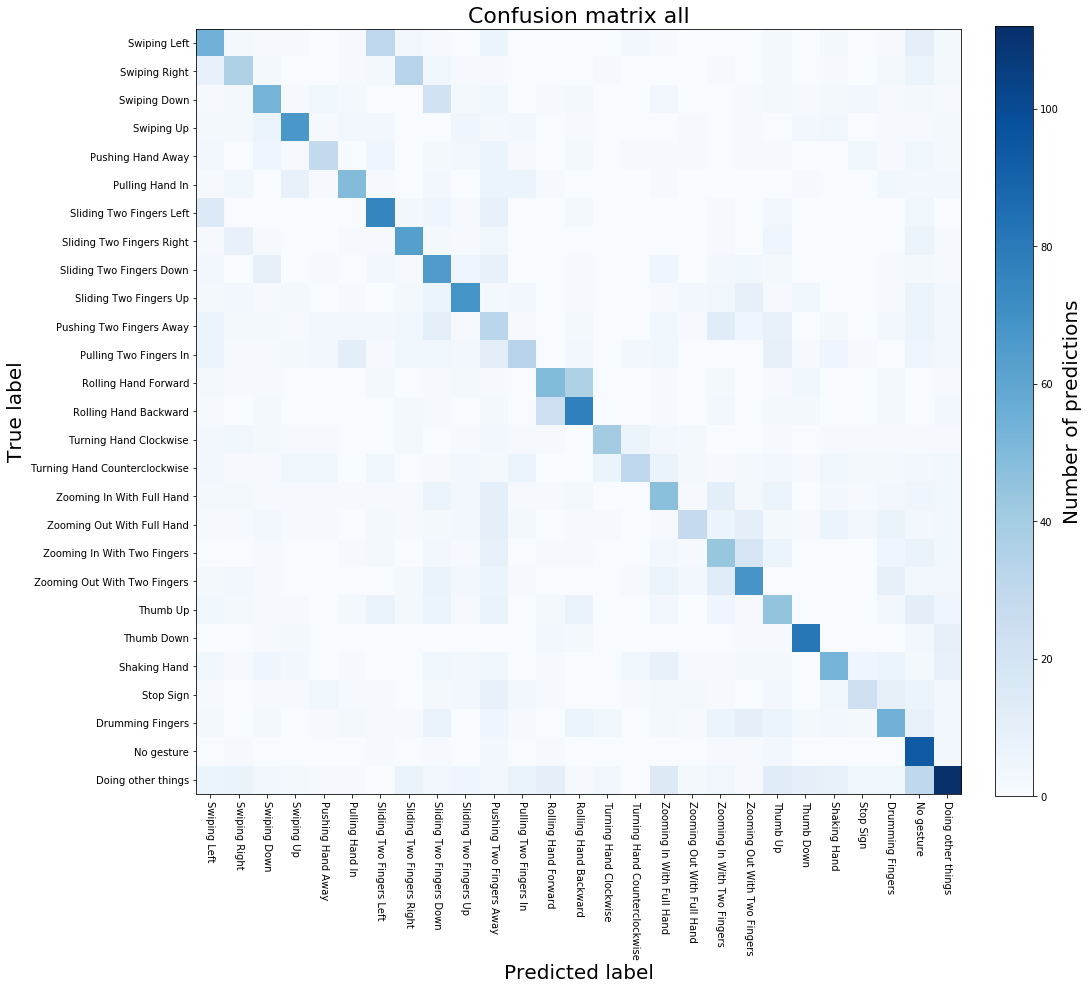

In [17]:
for avg in ['weighted', 'macro', 'micro']:
  print(avg)
  print("Accuracy: {:.2f}%".format(100*metrics.accuracy_score(y_test_true, prediction)))
  print("Precision: {:.2f}%".format(100*metrics.precision_score(y_test_true, prediction, average=avg)))
  print("Recall: {:.2f}%".format(100*metrics.recall_score(y_test_true, prediction, average=avg)))
  print("f1_score: {:.2f}%".format(100*metrics.f1_score(y_test_true, prediction, average=avg)))

confusion_matrix = metrics.confusion_matrix(y_test_true, prediction)

label_axis = sorted(label_class_dict, key = label_class_dict.__getitem__)


# Plot the confusion matrix
plt.figure(figsize=(15, 15))
im = plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)

plt.title("Confusion matrix "+db_type, fontsize = 22)
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Number of predictions', fontsize = 20)
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, label_axis, rotation=-90)
plt.yticks(tick_marks, label_axis)
plt.ylabel('True label', fontsize = 20)
plt.xlabel('Predicted label', fontsize = 20)
plt.savefig('confusion_matrix_'+db_type, bbox_inches='tight' )
plt.show()